In [4]:
import numpy as np
import math
import random

patterns = []
classes = []

filename = 'Iris_data.txt'
file = open(filename,'r')

for line in file.readlines():
    row = line.strip().split(',')
    patterns.append(row[0:4])
    classes.append(row[4])
print("Iris Data Loaded")
file.close

patterns = np.asarray(patterns,dtype=np.float32)

sample_no = np.random.randint(0,len(patterns))

print("Sample pattern: " + str(patterns[int(sample_no)]))
print("Class of the above pattern: " + str(classes[int(sample_no)]))
    

Iris Data Loaded
Sample pattern: [ 5.5999999   2.70000005  4.19999981  1.29999995]
Class of the above pattern: Iris-versicolor


In [5]:
#A heuristic formula for calculating no. of map units
#source: https://stackoverflow.com/questions/19163214/kohonen-self-organizing-maps-determining-the-number-of-neurons-and-grid-size

def mapunits(input_len,size='small'):
    
    heuristic_map_units = 5*input_len**0.54321
     
    if size == 'big':
        heuristic_map_units = 4*(heuristic_map_units)
    else:
        heuristic_map_units = 0.25*(heuristic_map_units)
        
    return heuristic_map_units
        
        
map_units = mapunits(len(patterns),size='big')
print("Heuristically computed appropriate no. of map units: "+str(int(map_units)))

#For reference purpose only - however this function can be used to automatically calculate the SOM dimensions
#from data length. I will still be specifying the SOM dimensions manually, anyway.

Heuristically computed appropriate no. of map units: 304


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def Eucli_dists(MAP,x):
    x = x.reshape((1,1,-1))
    #print(x)
    Eucli_MAP = MAP - x
    Eucli_MAP = Eucli_MAP**2
    Eucli_MAP = np.sqrt(np.sum(Eucli_MAP,2))
    return Eucli_MAP

input_dimensions = 4

map_width = 9
map_height = 5
MAP = np.random.uniform(size=(map_height,map_width,input_dimensions))
prev_MAP = np.zeros((map_height,map_width,input_dimensions))

radius0 = max(map_width,map_height)/2
learning_rate0 = 0.1

coordinate_map = np.zeros([map_height,map_width,2],dtype=np.int32)

for i in range(0,map_height):
    for j in range(0,map_width):
        coordinate_map[i][j] = [i,j]

epochs = 500
radius=radius0
learning_rate = learning_rate0
max_iterations = len(patterns)+1
too_many_iterations = 10*max_iterations

convergence = [1]

timestep=1
e=0.001 
flag=0

epoch=0
while epoch<epochs:
    
    shuffle = np.random.randint(len(patterns), size=len(patterns))
    for i in range(len(patterns)):
        
        # difference between prev_MAP and MAP
        J = np.linalg.norm(MAP - prev_MAP)
        #print(J)
        # J = || euclidean distance between previous MAP and current MAP  ||

        if  J <= e: #if converged (convergence criteria)
            flag=1
            break
            
        else:
            
            #if timestep == max_iterations and timestep != too_many_iterations:
            #    epochs += 1
            #    max_iterations = epochs*len(patterns)
            
            pattern = patterns[shuffle[i]]
            pattern_ary = np.tile(pattern, (map_height, map_width, 1))
            Eucli_MAP = np.linalg.norm(pattern_ary - MAP, axis=2)
            
            # Get the best matching unit(BMU) which is the one with the smallest Euclidean distance
            BMU = np.unravel_index(np.argmin(Eucli_MAP, axis=None), Eucli_MAP.shape)
            #BMU[1] = np.argmin(Eucli_MAP, 1)[int(BMU[0])]
    
            #Eucli_from_BMU = Eucli_dists(coordinate_map,BMU)  
        
            prev_MAP = np.copy(MAP)
             
            for i in range(map_height):
                for j in range(map_width):
                    distance = np.linalg.norm([i - BMU[0], j - BMU[1]])
                    if distance <= radius:
                        #theta = math.exp(-(distance**2)/(2*(radius**2)))
                        MAP[i][j] = MAP[i][j] + learning_rate*(pattern-MAP[i][j])
            
            learning_rate = learning_rate0*(1-(epoch/epochs))
            #time_constant = max_iterations/math.log(radius) 
            radius = radius0*math.exp(-epoch/epochs)
            #print([learning_rate, radius])
            
            timestep+=1
    
    if J < min(convergence):
        print('Lower error found: %s' %str(J) + ' at epoch: %s' % str(epoch))
        print('\tLearning rate: ' + str(learning_rate))
        print('\tNeighbourhood radius: ' + str(radius))
        MAP_final = MAP
    convergence.append(J)
    
    if flag==1:
        break
    epoch+=1

Lower error found: 0.881225586589 at epoch: 1
	Learning rate: 0.0998
	Neighbourhood radius: 4.491008994002999
Lower error found: 0.333097619731 at epoch: 2
	Learning rate: 0.09960000000000001
	Neighbourhood radius: 4.482035952047962
Lower error found: 0.301310596631 at epoch: 29
	Learning rate: 0.0942
	Neighbourhood radius: 4.246424763465593
Lower error found: 0.294679389196 at epoch: 55
	Learning rate: 0.08900000000000001
	Neighbourhood radius: 4.031253608834377
Lower error found: 0.156971807579 at epoch: 62
	Learning rate: 0.08760000000000001
	Neighbourhood radius: 3.975209283972379
Lower error found: 0.155987997056 at epoch: 143
	Learning rate: 0.0714
	Neighbourhood radius: 3.380681771760987
Lower error found: 0.150998780207 at epoch: 151
	Learning rate: 0.0698
	Neighbourhood radius: 3.3270212920028936
Lower error found: 0.11526419261 at epoch: 185
	Learning rate: 0.063
	Neighbourhood radius: 3.108304487868096
Lower error found: 0.0750511458477 at epoch: 204
	Learning rate: 0.059200

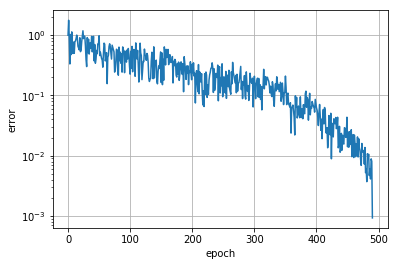

Number of timesteps: 73356
Final error: 0.000927032230858


In [25]:
# Show a plot of the error at each epoch to show convergence, but this is guaranteed in SOM
# due to the learning rate and neighbourhood decay
plt.plot(convergence)
plt.ylabel('error')
plt.xlabel('epoch')
plt.grid(True)
plt.yscale('log')
plt.show()
print('Number of timesteps: ' + str(timestep))
print('Final error: ' + str(J))

Red = Iris-Setosa
Blue = Iris-Virginica
Green = Iris-Versicolor


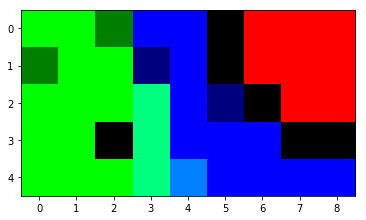

In [26]:
from scipy.misc import toimage
from PIL import Image


BMU = np.zeros([2],dtype=np.int32)
result_map = np.zeros([map_height,map_width,3],dtype=np.float32)

i=0
for pattern in patterns:
    
    pattern_ary = np.tile(pattern, (map_height, map_width, 1))
    Eucli_MAP = np.linalg.norm(pattern_ary - MAP_final, axis=2)

    # Get the best matching unit(BMU) which is the one with the smallest Euclidean distance
    BMU = np.unravel_index(np.argmin(Eucli_MAP, axis=None), Eucli_MAP.shape)
    
    x = BMU[0]
    y = BMU[1]
    
    if classes[i] == 'Iris-setosa':
        if result_map[x][y][0] <= 0.5:
            result_map[x][y] += np.asarray([0.5,0,0])
    elif classes[i] == 'Iris-virginica':
        if result_map[x][y][1] <= 0.5:
            result_map[x][y] += np.asarray([0,0.5,0])
    elif classes[i] == 'Iris-versicolor':
        if result_map[x][y][2] <= 0.5:
            result_map[x][y] += np.asarray([0,0,0.5])
    i+=1
result_map = np.flip(result_map,0)
    
#print result_map

print("Red = Iris-Setosa")
print("Blue = Iris-Virginica")
print("Green = Iris-Versicolor")

plt.imshow(result_map, interpolation='nearest')